In [1]:
import os
import json
import time
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

import datetime

In [21]:
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
from sklearn import model_selection

import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
df_train = pd.read_csv('train.csv', parse_dates=['first_active_month'])
df_test = pd.read_csv('test.csv', parse_dates=['first_active_month'])

In [4]:
print(df_train.shape,df_test.shape)

(201917, 6) (123623, 5)


In [5]:
df_train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913


Plot from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo

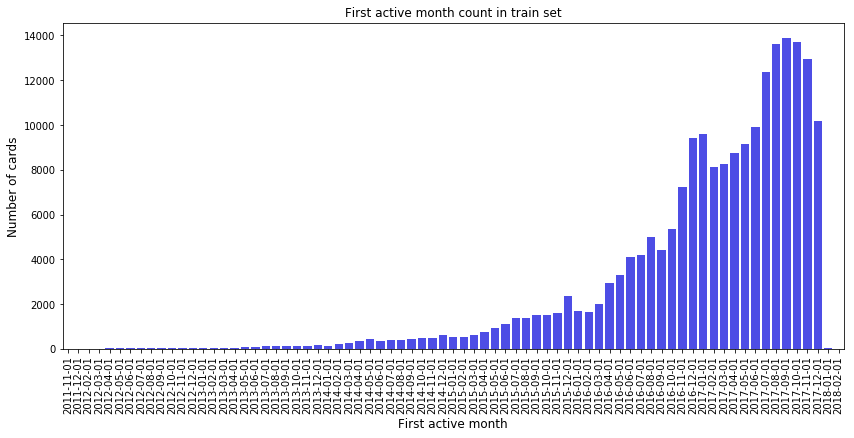

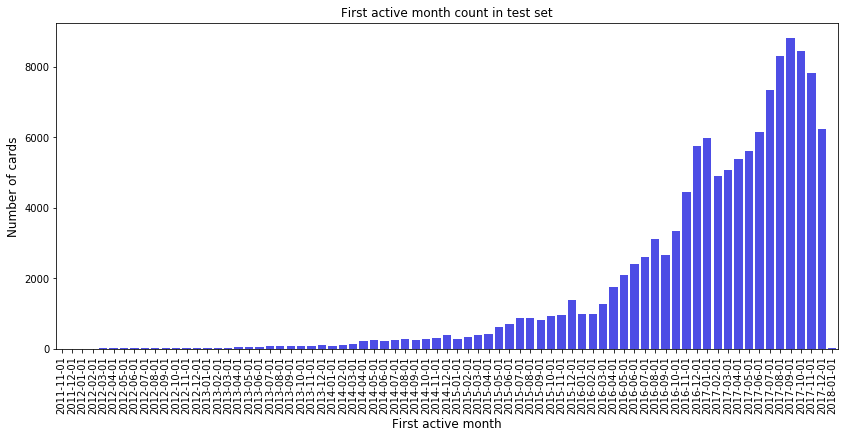

In [6]:
cnt_srs = df_train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='b')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = df_test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='b')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

In [7]:
df_train.corr()

,feature_1,feature_2,feature_3,target
feature_1,1.000000,-0.130969,0.583092,-0.014251
feature_2,-0.130969,1.000000,0.060925,-0.006242
feature_3,0.583092,0.060925,1.000000,-0.008125
target,-0.014251,-0.006242,-0.008125,1.000000


### feature_1 and feature_3 are strongly correlated. The rest are weak correlations. Perhaps a feature combination??

In [8]:
df_train["month"] = df_train["first_active_month"].dt.month
df_test["month"] = df_test["first_active_month"].dt.month

df_train["year"] = df_train["first_active_month"].dt.year
df_test["year"] = df_test["first_active_month"].dt.year

df_train['elapsed_time'] = (datetime.date(2018, 2, 1) - df_train['first_active_month'].dt.date).dt.days
df_test['elapsed_time'] = (datetime.date(2018, 2, 1) - df_test['first_active_month'].dt.date).dt.days

## Note:: The last date for the first_active_month from the plots above is 2018-02-01

df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,92


From various kernels, and intuitively, the elapsed time for which the account has been active affects the loyalty score

In [9]:
# Much easier way to add one_hot_encoding for categorical variables than my last notebook

df_train = pd.get_dummies(df_train, columns=['feature_1', 'feature_2','feature_3'])
df_test = pd.get_dummies(df_test, columns=['feature_1', 'feature_2','feature_3'])
df_train.head()

,first_active_month,card_id,target,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1
0,2017-06-01,C_ID_92a2005557,-0.820283,6,2017,245,0,0,0,0,1,0,1,0,0,1
1,2017-01-01,C_ID_3d0044924f,0.392913,1,2017,396,0,0,0,1,0,1,0,0,1,0
2,2016-08-01,C_ID_d639edf6cd,0.688056,8,2016,549,0,1,0,0,0,0,1,0,1,0
3,2017-09-01,C_ID_186d6a6901,0.142495,9,2017,153,0,0,0,1,0,0,0,1,1,0
4,2017-11-01,C_ID_cdbd2c0db2,-0.159749,11,2017,92,1,0,0,0,0,0,0,1,1,0


In [10]:
df_hist = pd.read_csv('historical_transactions.csv')
df_hist.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [11]:
df_hist = pd.get_dummies(df_hist, columns=['category_1','category_2','category_3','authorized_flag'])
df_hist.head()

,card_id,city_id,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_1_N,category_1_Y,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,authorized_flag_N,authorized_flag_Y
0,C_ID_4e6213e9bc,88,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,1,0,0,0,0,1,0,0,0,1
1,C_ID_4e6213e9bc,88,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,1,0,0,0,0,1,0,0,0,1
2,C_ID_4e6213e9bc,88,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,1,0,0,0,0,1,0,0,0,1
3,C_ID_4e6213e9bc,88,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,1,0,0,0,0,1,0,0,0,1
4,C_ID_4e6213e9bc,88,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,1,0,0,0,0,1,0,0,0,1


### In the above, we could also not encode category_1 and authorized_flag as one-hot, and just map the variables to 0's and 1's

### The function below is a variation on a set of kernels, principally https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737

In [12]:
def aggregate_transactions(df, prefix):  
    df.loc[:, 'purchase_date'] = pd.DatetimeIndex(df['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    # The above line converts pandas datetimeindex to unix time 
    # https://stackoverflow.com/questions/15203623/convert-pandas-datetimeindex-to-unix-time
    
    # The aggregate functions will be applied to each feature after grouping them by card_id
    agg_func = {
#         'authorized_flag_N': ['sum', 'mean'], -- comment this out -- 
        # does not exist in df_new -- make separate functions later
        'authorized_flag_Y': ['sum', 'mean'], 
        'category_1_N': ['mean'],
        'category_1_Y': ['mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp], # Gives range of values along an axis 
                                   #  https://docs.scipy.org/doc/numpy/reference/generated/numpy.ptp.html
        'month_lag': ['min', 'max']
    }
    
    agg_df = df.groupby(['card_id']).agg(agg_func)
    agg_df.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    df = (df.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    df = pd.merge(df, agg_df, on='card_id', how='left')
    
    return df

In [13]:
df_hist = aggregate_transactions(df_hist, prefix='hist_')

df_train = pd.merge(df_train, df_hist, on='card_id',how='left')
df_test = pd.merge(df_test, df_hist, on='card_id',how='left')

df_train.head()

,first_active_month,card_id,target,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,hist_transactions_count,hist_authorized_flag_Y_sum,hist_authorized_flag_Y_mean,hist_category_1_N_mean,hist_category_1_Y_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,2017-06-01,C_ID_92a2005557,-0.820283,6,2017,245,0,0,0,0,1,0,1,0,0,1,260,247.0,0.950000,1.000000,0.000000,0.988462,0.0,0.0,0.000000,0.011538,0.984615,0.015385,0.000000,94,-165.968739,-0.638341,2.258395,-0.739395,0.212139,4,0.015385,1,0,0.123314,20977987.0,-8,0
1,2017-01-01,C_ID_3d0044924f,0.392913,1,2017,396,0,0,0,1,0,1,0,0,1,0,350,339.0,0.968571,0.911429,0.088571,0.911429,0.0,0.0,0.000000,0.000000,0.000000,0.788571,0.205714,142,-210.006336,-0.600018,4.630299,-0.742400,0.384967,543,1.551429,10,-1,1.510777,33717687.0,-12,0
2,2016-08-01,C_ID_d639edf6cd,0.688056,8,2016,549,0,1,0,0,0,0,1,0,1,0,43,41.0,0.953488,1.000000,0.000000,0.093023,0.0,0.0,0.000000,0.906977,1.000000,0.000000,0.000000,13,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0,0.000000,0,0,0.000000,35635623.0,-13,0
3,2017-09-01,C_ID_186d6a6901,0.142495,9,2017,153,0,0,0,1,0,0,0,1,1,0,77,77.0,1.000000,0.844156,0.155844,0.155844,0.0,0.0,0.688312,0.000000,0.000000,0.883117,0.090909,50,-49.491364,-0.642745,1.445596,-0.740897,0.261624,84,1.090909,3,-1,0.588974,13375339.0,-5,0
4,2017-11-01,C_ID_cdbd2c0db2,-0.159749,11,2017,92,1,0,0,0,0,0,0,1,1,0,133,128.0,0.962406,0.887218,0.112782,0.075188,0.0,0.0,0.804511,0.007519,0.000000,0.947368,0.052632,66,-48.687656,-0.366073,7.193041,-0.746156,1.352094,182,1.368421,12,1,1.896862,9405641.0,-3,0


In [14]:
print(df_train.shape, df_test.shape)

(201917, 43) (123623, 42)


In [15]:
df_new = pd.read_csv('new_merchant_transactions.csv')
df_new.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [16]:
df_new = pd.get_dummies(df_new, columns=['category_1','category_2','category_3','authorized_flag'])
df_new.head()

,card_id,city_id,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_1_N,category_1_Y,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,authorized_flag_Y
0,C_ID_415bb3a509,107,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,9,19,1,0,1,0,0,0,0,0,1,0,1
1,C_ID_415bb3a509,140,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,9,19,1,0,1,0,0,0,0,0,1,0,1
2,C_ID_415bb3a509,330,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,9,14,1,0,1,0,0,0,0,0,1,0,1
3,C_ID_415bb3a509,-1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,-1,8,0,1,0,0,0,0,0,0,1,0,1
4,C_ID_ef55cf8d4b,-1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,-1,29,0,1,0,0,0,0,0,0,1,0,1


In [17]:
df_new = aggregate_transactions(df_new, prefix='new_')

df_train = pd.merge(df_train, df_new, on='card_id',how='left')
df_test = pd.merge(df_test, df_new, on='card_id',how='left')

df_train.head()

,first_active_month,card_id,target,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,hist_transactions_count,hist_authorized_flag_Y_sum,hist_authorized_flag_Y_mean,hist_category_1_N_mean,hist_category_1_Y_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max,new_transactions_count,new_authorized_flag_Y_sum,new_authorized_flag_Y_mean,new_category_1_N_mean,new_category_1_Y_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_date_ptp,new_month_lag_min,new_month_lag_max
0,2017-06-01,C_ID_92a2005557,-0.820283,6,2017,245,0,0,0,0,1,0,1,0,0,1,260,247.0,0.950000,1.000000,0.000000,0.988462,0.0,0.0,0.000000,0.011538,0.984615,0.015385,0.000000,94,-165.968739,-0.638341,2.258395,-0.739395,0.212139,4,0.015385,1,0,0.123314,20977987.0,-8,0,23.0,23.0,1.0,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,23.0,-13.244202,-0.575835,-0.296112,-0.724368,0.135812,0.0,0.000000,0.0,0.0,0.000000,4742309.0,1.0,2.0
1,2017-01-01,C_ID_3d0044924f,0.392913,1,2017,396,0,0,0,1,0,1,0,0,1,0,350,339.0,0.968571,0.911429,0.088571,0.911429,0.0,0.0,0.000000,0.000000,0.000000,0.788571,0.205714,142,-210.006336,-0.600018,4.630299,-0.742400,0.384967,543,1.551429,10,-1,1.510777,33717687.0,-12,0,6.0,6.0,1.0,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,6.0,-4.355735,-0.725956,-0.701858,-0.739410,0.014326,6.0,1.000000,1.0,1.0,0.000000,4887632.0,1.0,2.0
2,2016-08-01,C_ID_d639edf6cd,0.688056,8,2016,549,0,1,0,0,0,0,1,0,1,0,43,41.0,0.953488,1.000000,0.000000,0.093023,0.0,0.0,0.000000,0.906977,1.000000,0.000000,0.000000,13,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0,0.000000,0,0,0.000000,35635623.0,-13,0,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,0.000000,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.000000,0.0,0.0,NaN,0.0,2.0,2.0
3,2017-09-01,C_ID_186d6a6901,0.142495,9,2017,153,0,0,0,1,0,0,0,1,1,0,77,77.0,1.000000,0.844156,0.155844,0.155844,0.0,0.0,0.688312,0.000000,0.000000,0.883117,0.090909,50,-49.491364,-0.642745,1.445596,-0.740897,0.261624,84,1.090909,3,-1,0.588974,13375339.0,-5,0,7.0,7.0,1.0,0.857143,0.142857,0.000000,0.0,0.000000,0.857143,0.0,0.0,0.857143,0.000000,7.0,-4.654372,-0.664910,-0.566740,-0.734135,0.065882,5.0,0.714286,1.0,-1.0,0.755929,3625505.0,1.0,2.0
4,2017-11-01,C_ID_cdbd2c0db2,-0.159749,11,2017,92,1,0,0,0,0,0,0,1,1,0,133,128.0,0.962406,0.887218,0.112782,0.075188,0.0,0.0,0.804511,0.007519,0.000000,0.947368,0.052632,66,-48.687656,-0.366073,7.193041,-0.746156,1.352094,182,1.368421,12,1,1.896862,9405641.0,-3,0,36.0,36.0,1.0,0.944444,0.055556,0.055556,0.0,0.194444,0.694444,0.0,0.0,0.944444,0.027778,36.0,-19.926237,-0.553507,0.450886,-0.739395,0.223821,35.0,0.972222,2.0,-1.0,0.376913,4949682.0,1.0,2.0


In [18]:
df_train.isna().sum() # We should deal with the nans later

first_active_month                 0
card_id                            0
target                             0
month                              0
year                               0
elapsed_time                       0
feature_1_1                        0
feature_1_2                        0
feature_1_3                        0
feature_1_4                        0
feature_1_5                        0
feature_2_1                        0
feature_2_2                        0
feature_2_3                        0
feature_3_0                        0
feature_3_1                        0
hist_transactions_count            0
hist_authorized_flag_Y_sum         0
hist_authorized_flag_Y_mean        0
hist_category_1_N_mean             0
hist_category_1_Y_mean             0
hist_category_2_1.0_mean           0
hist_category_2_2.0_mean           0
hist_category_2_3.0_mean           0
hist_category_2_4.0_mean           0
hist_category_2_5.0_mean           0
hist_category_3_A_mean             0
h

In [19]:
print(df_train.shape,df_test.shape)

(201917, 70) (123623, 69)


### lgb training params are a bit different from what we saw before. Refer https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737.  This needs to be understood better. 

In [24]:
target = df_train['target']
cols_to_drop = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in cols_to_drop]
features = list(df_train[use_cols].columns)

df_train[features].head()

,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,hist_transactions_count,hist_authorized_flag_Y_sum,hist_authorized_flag_Y_mean,hist_category_1_N_mean,hist_category_1_Y_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max,new_transactions_count,new_authorized_flag_Y_sum,new_authorized_flag_Y_mean,new_category_1_N_mean,new_category_1_Y_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_date_ptp,new_month_lag_min,new_month_lag_max
0,6,2017,245,0,0,0,0,1,0,1,0,0,1,260,247.0,0.950000,1.000000,0.000000,0.988462,0.0,0.0,0.000000,0.011538,0.984615,0.015385,0.000000,94,-165.968739,-0.638341,2.258395,-0.739395,0.212139,4,0.015385,1,0,0.123314,20977987.0,-8,0,23.0,23.0,1.0,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,23.0,-13.244202,-0.575835,-0.296112,-0.724368,0.135812,0.0,0.000000,0.0,0.0,0.000000,4742309.0,1.0,2.0
1,1,2017,396,0,0,0,1,0,1,0,0,1,0,350,339.0,0.968571,0.911429,0.088571,0.911429,0.0,0.0,0.000000,0.000000,0.000000,0.788571,0.205714,142,-210.006336,-0.600018,4.630299,-0.742400,0.384967,543,1.551429,10,-1,1.510777,33717687.0,-12,0,6.0,6.0,1.0,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,6.0,-4.355735,-0.725956,-0.701858,-0.739410,0.014326,6.0,1.000000,1.0,1.0,0.000000,4887632.0,1.0,2.0
2,8,2016,549,0,1,0,0,0,0,1,0,1,0,43,41.0,0.953488,1.000000,0.000000,0.093023,0.0,0.0,0.000000,0.906977,1.000000,0.000000,0.000000,13,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0,0.000000,0,0,0.000000,35635623.0,-13,0,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,0.000000,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.000000,0.0,0.0,NaN,0.0,2.0,2.0
3,9,2017,153,0,0,0,1,0,0,0,1,1,0,77,77.0,1.000000,0.844156,0.155844,0.155844,0.0,0.0,0.688312,0.000000,0.000000,0.883117,0.090909,50,-49.491364,-0.642745,1.445596,-0.740897,0.261624,84,1.090909,3,-1,0.588974,13375339.0,-5,0,7.0,7.0,1.0,0.857143,0.142857,0.000000,0.0,0.000000,0.857143,0.0,0.0,0.857143,0.000000,7.0,-4.654372,-0.664910,-0.566740,-0.734135,0.065882,5.0,0.714286,1.0,-1.0,0.755929,3625505.0,1.0,2.0
4,11,2017,92,1,0,0,0,0,0,0,1,1,0,133,128.0,0.962406,0.887218,0.112782,0.075188,0.0,0.0,0.804511,0.007519,0.000000,0.947368,0.052632,66,-48.687656,-0.366073,7.193041,-0.746156,1.352094,182,1.368421,12,1,1.896862,9405641.0,-3,0,36.0,36.0,1.0,0.944444,0.055556,0.055556,0.0,0.194444,0.694444,0.0,0.0,0.944444,0.027778,36.0,-19.926237,-0.553507,0.450886,-0.739395,0.223821,35.0,0.972222,2.0,-1.0,0.376913,4949682.0,1.0,2.0


In [25]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.75176	valid_1's rmse: 3.81825
[200]	training's rmse: 3.69556	valid_1's rmse: 3.78473
[300]	training's rmse: 3.65294	valid_1's rmse: 3.76535
[400]	training's rmse: 3.61698	valid_1's rmse: 3.75108
[500]	training's rmse: 3.58733	valid_1's rmse: 3.74145
[600]	training's rmse: 3.56145	valid_1's rmse: 3.73414
[700]	training's rmse: 3.53882	valid_1's rmse: 3.72821
[800]	training's rmse: 3.51856	valid_1's rmse: 3.72372
[900]	training's rmse: 3.49994	valid_1's rmse: 3.72059
[1000]	training's rmse: 3.48334	valid_1's rmse: 3.71783
[1100]	training's rmse: 3.46768	valid_1's rmse: 3.7153
[1200]	training's rmse: 3.45334	valid_1's rmse: 3.71337
[1300]	training's rmse: 3.44047	valid_1's rmse: 3.71204
[1400]	training's rmse: 3.42896	valid_1's rmse: 3.71105
[1500]	training's rmse: 3.41707	valid_1's rmse: 3.71006
[1600]	training's rmse: 3.40655	valid_1's rmse: 3.70966
[1700]	training's rmse: 3.39574	valid_1's 

In [26]:
validation_score = np.sqrt(mean_squared_error(target, oof))
validation_score

3.6910106961675697

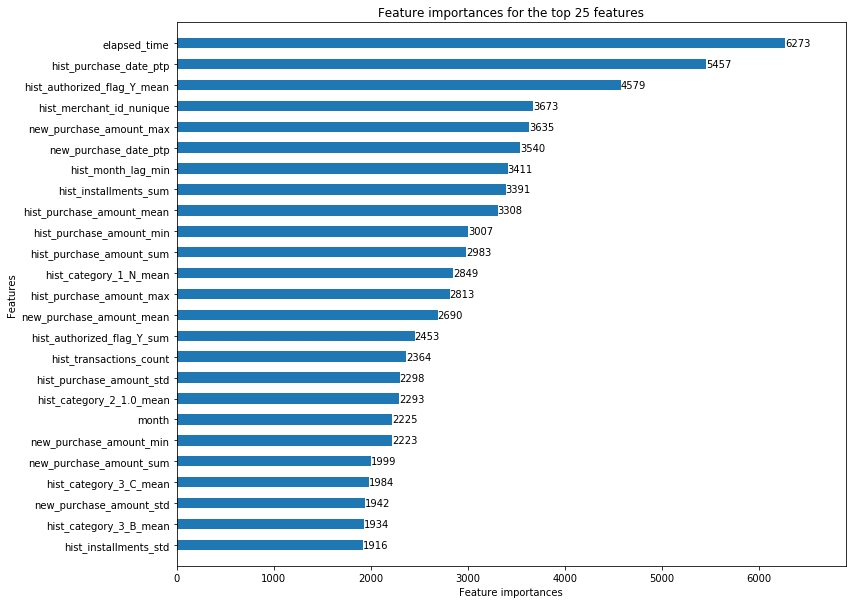

In [30]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(clf, max_num_features=25, height=0.5, ax=ax, \
                    title='Feature importances for the top 25 features',\
                    xlabel='Feature importances', ylabel='Features')
ax.grid(False);

In [31]:
df_submission = pd.DataFrame({"card_id": df_test["card_id"].values})
df_submission["target"] = predictions
df_submission.to_csv("mds_einstein_sub3.csv", index=False)

## LB score of 3.737 (which is pretty good right now)
### Future outlook::
#### Use merchants.csv
#### Work on combination of features, polynomial features
#### Work on reducing overfitting by feature selection
#### Try XGBoost and Catboost
#### Try and handle the 2207 training set entries with a target < -30